In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os, re
import seaborn as sns

### For each dataset folder, load each one, get the total timespan of the CSV file, calculate gaps > 10 min, then calculate fraction of gaps over total duration.

In [13]:
def calculate_gaps_in_glucose_data(folder_path):
    # Compile the pattern to match the filenames
    pattern = re.compile(r'(train|test)_[a-f0-9]+.csv')
    
    # Find all CSV files in the folder that match the pattern
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    
    # List to store the results
    results = []
    
    # Loop through each CSV file that matches the pattern
    for file in csv_files:
        filename = os.path.basename(file)
        
        if pattern.match(filename):
            
            # Read the CSV file into a dataframe
            data = pd.read_csv(file, low_memory=False)

            # Strip any whitespace from the 'type' column and convert to lowercase
            data['type'] = data['type'].str.strip().str.lower()

            # Filter only rows where "type" is "cbg"
            cbg_data = data[data['type'] == 'cbg']

            # Ensure the data is sorted by time
            cbg_data = cbg_data.sort_values(by='time').reset_index(drop=True)

            # If there is no data or only one row, skip this file
            if cbg_data.shape[0] < 2:
                print(f"Skipping {filename}: not enough 'cbg' data points.")
                continue

            # Convert the 'time' column to datetime objects using a flexible format
            cbg_data['time'] = pd.to_datetime(cbg_data['time'], errors='coerce', utc=True)

            # Drop rows with non-convertible 'time' values (if any)
            cbg_data = cbg_data.dropna(subset=['time'])

            # Calculate total time elapsed (from the first to the last timestamp)
            total_time_elapsed = (cbg_data['time'].iloc[-1] - cbg_data['time'].iloc[0]).total_seconds() / 60  # in minutes
            
            # Calculate the differences between consecutive timestamps
            time_diffs = cbg_data['time'].diff().dt.total_seconds().div(60).fillna(0)  # in minutes
            
            # Identify gaps (where the difference is more than 5 minutes)
            gaps = time_diffs[time_diffs > 10]
            
            # Calculate total gap time
            total_gap_time = gaps.sum()
            
            # Calculate the fraction of time that is gaps
            gap_fraction = total_gap_time / total_time_elapsed if total_time_elapsed > 0 else 0
            
            # Store the results for this file
            results.append({
                'file': filename,
                'total_time_elapsed (min)': total_time_elapsed,
                'total_gap_time (min)': total_gap_time,
                'gap_fraction': gap_fraction
            })
    
    # Create a dataframe to display the results as a table
    results_df = pd.DataFrame(results)
        
    # Print the results in a table format
    from IPython.display import display, HTML
    display(HTML("<style>.dataframe { width:100% !important; }</style>"))
    # Display the DataFrame
    #display(results_df)   # Uncomment if you want to see the raw numbers

    # Plot a histogram of gap_fraction
    plt.figure(figsize=(10, 6))
    sns.histplot(results_df['gap_fraction'], bins=100, kde=False)
    plt.xlim(0,1)
    plt.ylim(0,40)
    plt.title('Histogram of Gap Fraction Across Datasets')
    plt.xlabel('Gap Fraction')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

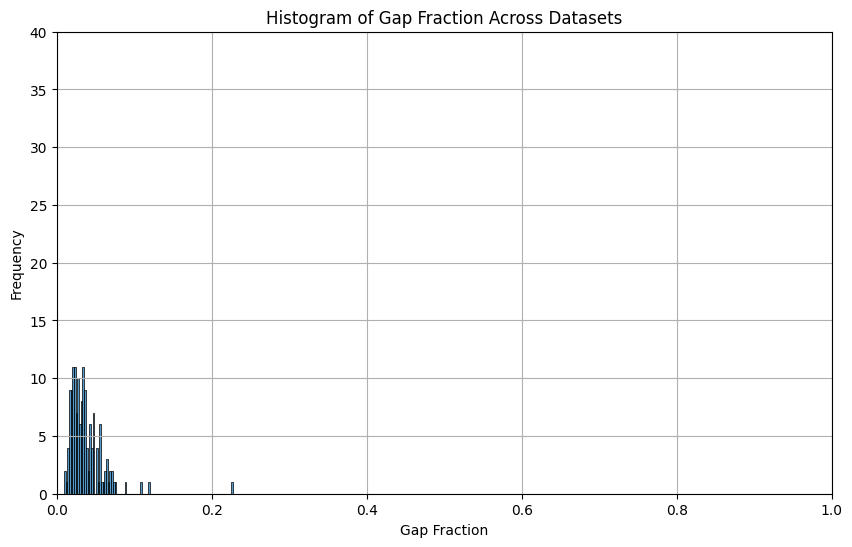

In [14]:
# Example usage: use your provided folder path
folder_path = 'Tidepool_Datasets/Tidepool-JDRF-HCL150-train/train-data'
calculate_gaps_in_glucose_data(folder_path)

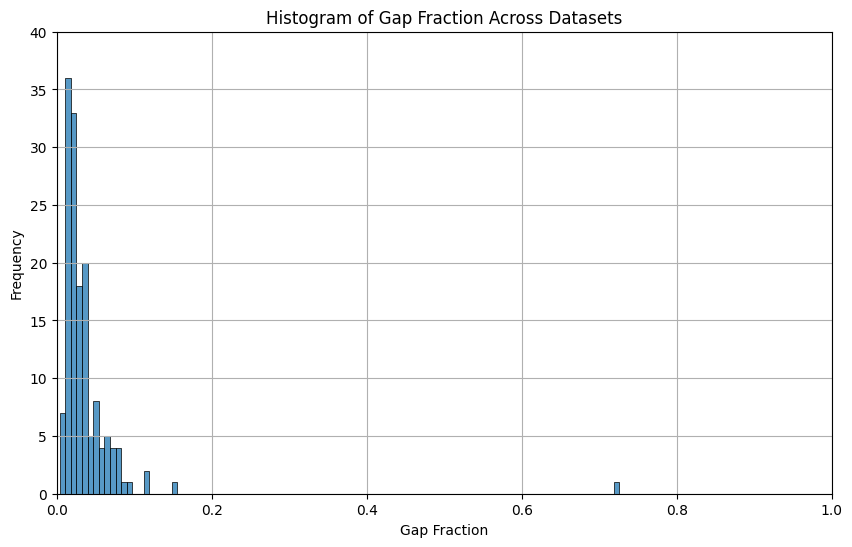

In [15]:
# Example usage: use your provided folder path
folder_path = 'Tidepool_Datasets/Tidepool-JDRF-HCL150-test/test-data'
calculate_gaps_in_glucose_data(folder_path)

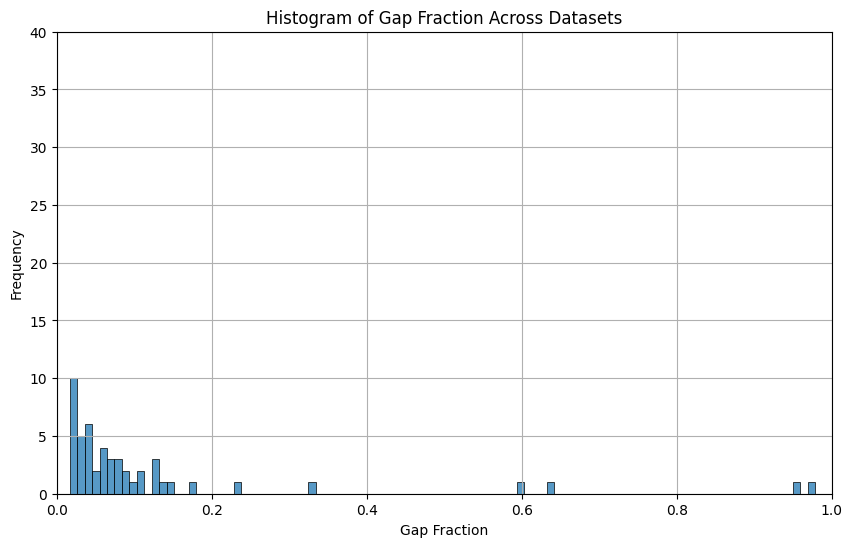

In [16]:
# Example usage: use your provided folder path
folder_path = 'Tidepool_Datasets/Tidepool-JDRF-PA50-train/train-data'
calculate_gaps_in_glucose_data(folder_path)

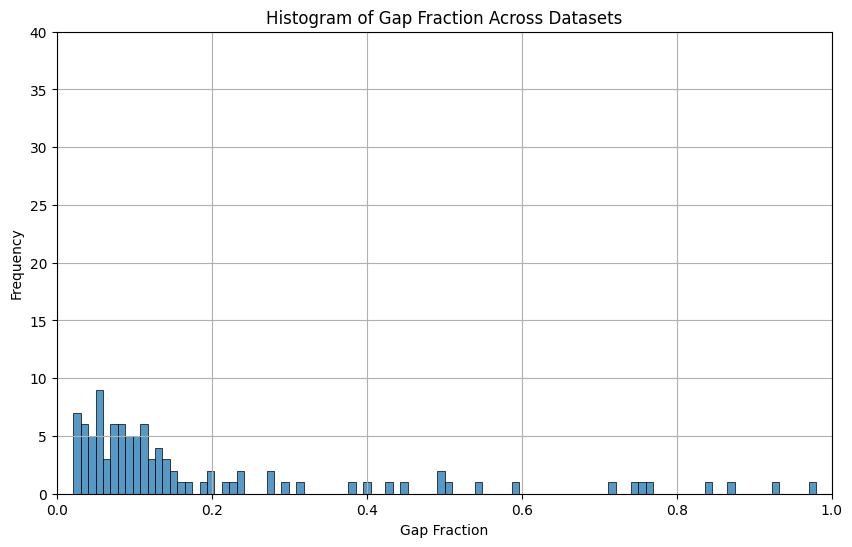

In [17]:
# Example usage: use your provided folder path
folder_path = 'Tidepool_Datasets/Tidepool-JDRF-SAP100-train/train-data'
calculate_gaps_in_glucose_data(folder_path)

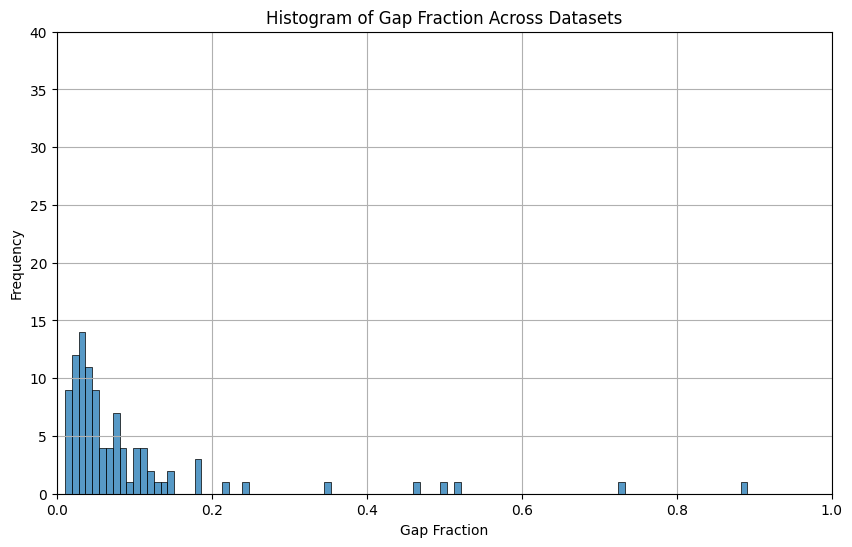

In [18]:
# Example usage: use your provided folder path
folder_path = 'Tidepool_Datasets/Tidepool-JDRF-SAP100-test/test-data'
calculate_gaps_in_glucose_data(folder_path)